# Importing libraries and pre-processed data

In [ ]:
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Dense, Flatten, Dropout, SeparableConv1D
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import librosa
import librosa.display
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,r2_score, completeness_score, accuracy_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.preprocessing import StandardScaler
from os import listdir
from os.path import isfile, join
from tensorflow.keras.utils import plot_model,to_categorical
from google.colab import drive
import scipy
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/'CMPT 340 Project'/audio_and_txt_files

Mounted at /content/gdrive
/content/gdrive/MyDrive/CMPT 340 Project/audio_and_txt_files


In [ ]:
dataset = pd.read_pickle('Final_Data.pkl') 

dataset_non_Augmented = dataset[dataset['rand int i'] == -1]
dataset_Augmented = dataset[dataset['rand int i'] != -1]
dataset_Augmented.reset_index(inplace=True)

In [ ]:
dataset = dataset[ dataset["Diagnosis"] != "Asthma"]
dataset = dataset[ dataset["Diagnosis"] != "LRTI"  ]
dataset.reset_index(inplace=True)

dataset_non_Augmented = dataset_non_Augmented[dataset_non_Augmented["Diagnosis"] != "Asthma"]
dataset_non_Augmented = dataset_non_Augmented[dataset_non_Augmented["Diagnosis"] != "LRTI"]
dataset_non_Augmented.reset_index(inplace=True)

dataset_Augmented = dataset_Augmented[dataset_Augmented["Diagnosis"] != "Asthma"]
dataset_Augmented = dataset_Augmented[dataset_Augmented["Diagnosis"] != "LRTI"]
dataset_Augmented.reset_index(inplace=True)

Now we have the joined dataset as well as the split versions to properly organize our models testing and training

In [ ]:
dataset_sequential = dataset.copy() 
dataset

,index,Patient number,Age,Sex,Diagnosis,Binary_diagnosis,Recording index,new BMI,zero_crossing,centroids,energy,rand int i,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,Chest location_Al,Chest location_Ar,Chest location_Ll,Chest location_Lr,Chest location_Pl,Chest location_Pr,Chest location_Tc,Acquisition mode_mc,Acquisition mode_sc,Recording equipment_AKGC417L,Recording equipment_Litt3200,Recording equipment_LittC2SE,Recording equipment_Meditron
0,0,101,3.00,0,URTI,Unhealthy,1b1,19.385777,834,862,24.354544,-1,-583.074829,95.407684,57.615402,31.388035,28.196554,33.571594,31.646765,22.791107,16.666695,15.631426,14.037862,9.235232,5.834866,7.332277,10.597386,10.617828,7.180680,3.737869,2.680353,3.642111,5.495842,7.373888,8.116691,6.516584,3.175952,0.672749,0.915031,3.079237,...,1.728973e-07,1.738731e-07,1.769270e-07,1.728405e-07,1.709613e-07,1.697057e-07,1.698561e-07,1.716227e-07,1.743128e-07,1.806536e-07,1.831783e-07,1.743893e-07,1.328132e-07,1.112076e-07,24.108521,12.576147,13.513313,14.723985,16.083529,13.537544,28.755852,-0.015893,0.028519,-0.082620,0.048922,0.035543,0.010514,0,0,0,0,0,1,0,0,1,0,0,0,1
1,1,101,3.00,0,URTI,Unhealthy,1b1,19.385777,938,862,40.098251,-1,-529.150757,104.431587,70.155006,42.595573,31.283190,27.506977,22.269215,16.563374,15.326893,16.716825,14.707142,8.446252,3.871402,4.893015,8.417205,9.325685,6.879937,3.962098,2.855496,3.370863,4.458168,5.342813,5.608436,4.753032,2.933595,1.404434,1.264880,2.176501,...,2.542159e-07,2.599661e-07,2.753871e-07,2.632678e-07,2.556239e-07,2.714140e-07,2.835432e-07,3.009890e-07,3.235409e-07,3.527952e-07,4.131382e-07,5.203320e-07,6.602992e-07,7.155102e-07,21.529142,11.710819,13.348330,14.907793,16.954568,13.540970,28.758001,0.024129,0.015229,-0.107902,0.014130,0.014674,-0.004861,1,0,0,0,0,0,0,0,1,0,0,0,1
2,2,102,0.75,0,Healthy,Healthy,1b1,18.389942,1009,862,15.837536,-1,-596.955933,116.085419,60.695057,25.555992,26.209230,38.512352,36.051533,18.640724,3.533884,0.808337,5.736544,9.657865,9.137486,5.530644,2.170750,2.102858,5.248150,7.930713,7.101245,4.055319,2.352255,3.208253,4.845040,5.344265,4.519351,3.379910,2.771019,2.687288,...,1.025937e-07,1.011247e-07,1.017891e-07,1.008913e-07,9.857648e-08,9.736862e-08,9.689317e-08,9.504856e-08,9.403183e-08,9.480667e-08,9.228317e-08,7.141852e-08,2.596839e-08,3.352563e-09,22.001710,11.461202,14.800548,15.227452,15.865647,13.587686,28.836766,0.059854,0.050555,-0.053679,0.046902,0.007503,0.004685,0,1,0,0,0,0,0,0,1,0,0,0,1
3,4,104,70.00,0,COPD,Unhealthy,1b1,28.470000,831,648,56.509598,-1,-424.268616,59.955784,50.275135,38.291904,27.447374,19.641413,15.319858,14.077450,14.971409,16.690376,17.948116,17.959871,16.606979,14.217122,11.247156,8.132569,5.296245,3.138010,1.914241,1.616304,2.000694,2.753793,3.620424,4.395525,4.869637,4.867006,4.361364,3.522510,...,4.886360e-09,4.704167e-09,4.539293e-09,4.387901e-09,4.252693e-09,4.133347e-09,4.022551e-09,3.930130e-09,3.847529e-09,3.776099e-09,3.719050e-09,3.672473e-09,3.640387e-09,3.618832e-09,24.231688,14.313585,17.410904,19.179523,40.675148,19.165556,19.578840,-0.020600,0.016854,-0.102233,0.004000,0.017646,0.002610,0,0,0,1,0,0,0,0,1,0,1,0,0
4,5,104,70.00,0,COPD,Unhealthy,1b1,28.470000,4268,1102,47.924110,-1,-443.015717,106.845009,74.780205,40.033150,16.150705,6.414668,5.623073,7.302594,8.734268,10.403658,12.732615,14.533298,14.256553,11.709416,8.095510,4.730742,2.155521,0.386362,-0.481122,-0.242964,0.982270,2.605332,3.957437,4.724201,4.930986,4.625820,3.759405,2.412742,...,1.074350e-10,1.033897e-10,9.973590e-11,9.637932e-11,9.337561e-11,9.072832e-11,8.827520e-11,8.622253e-11,8.439215e-11,8.281121e-11,8.154581e-11,8.051374e-11,7.980280e-11,7.932340e-11,19.341615,13.058082,17.626779,23.569384,38.163289,12.302099,12.288822,-0.020917,0.014159,-0.084030,0.027118,0.020544,0.004155,0,1,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

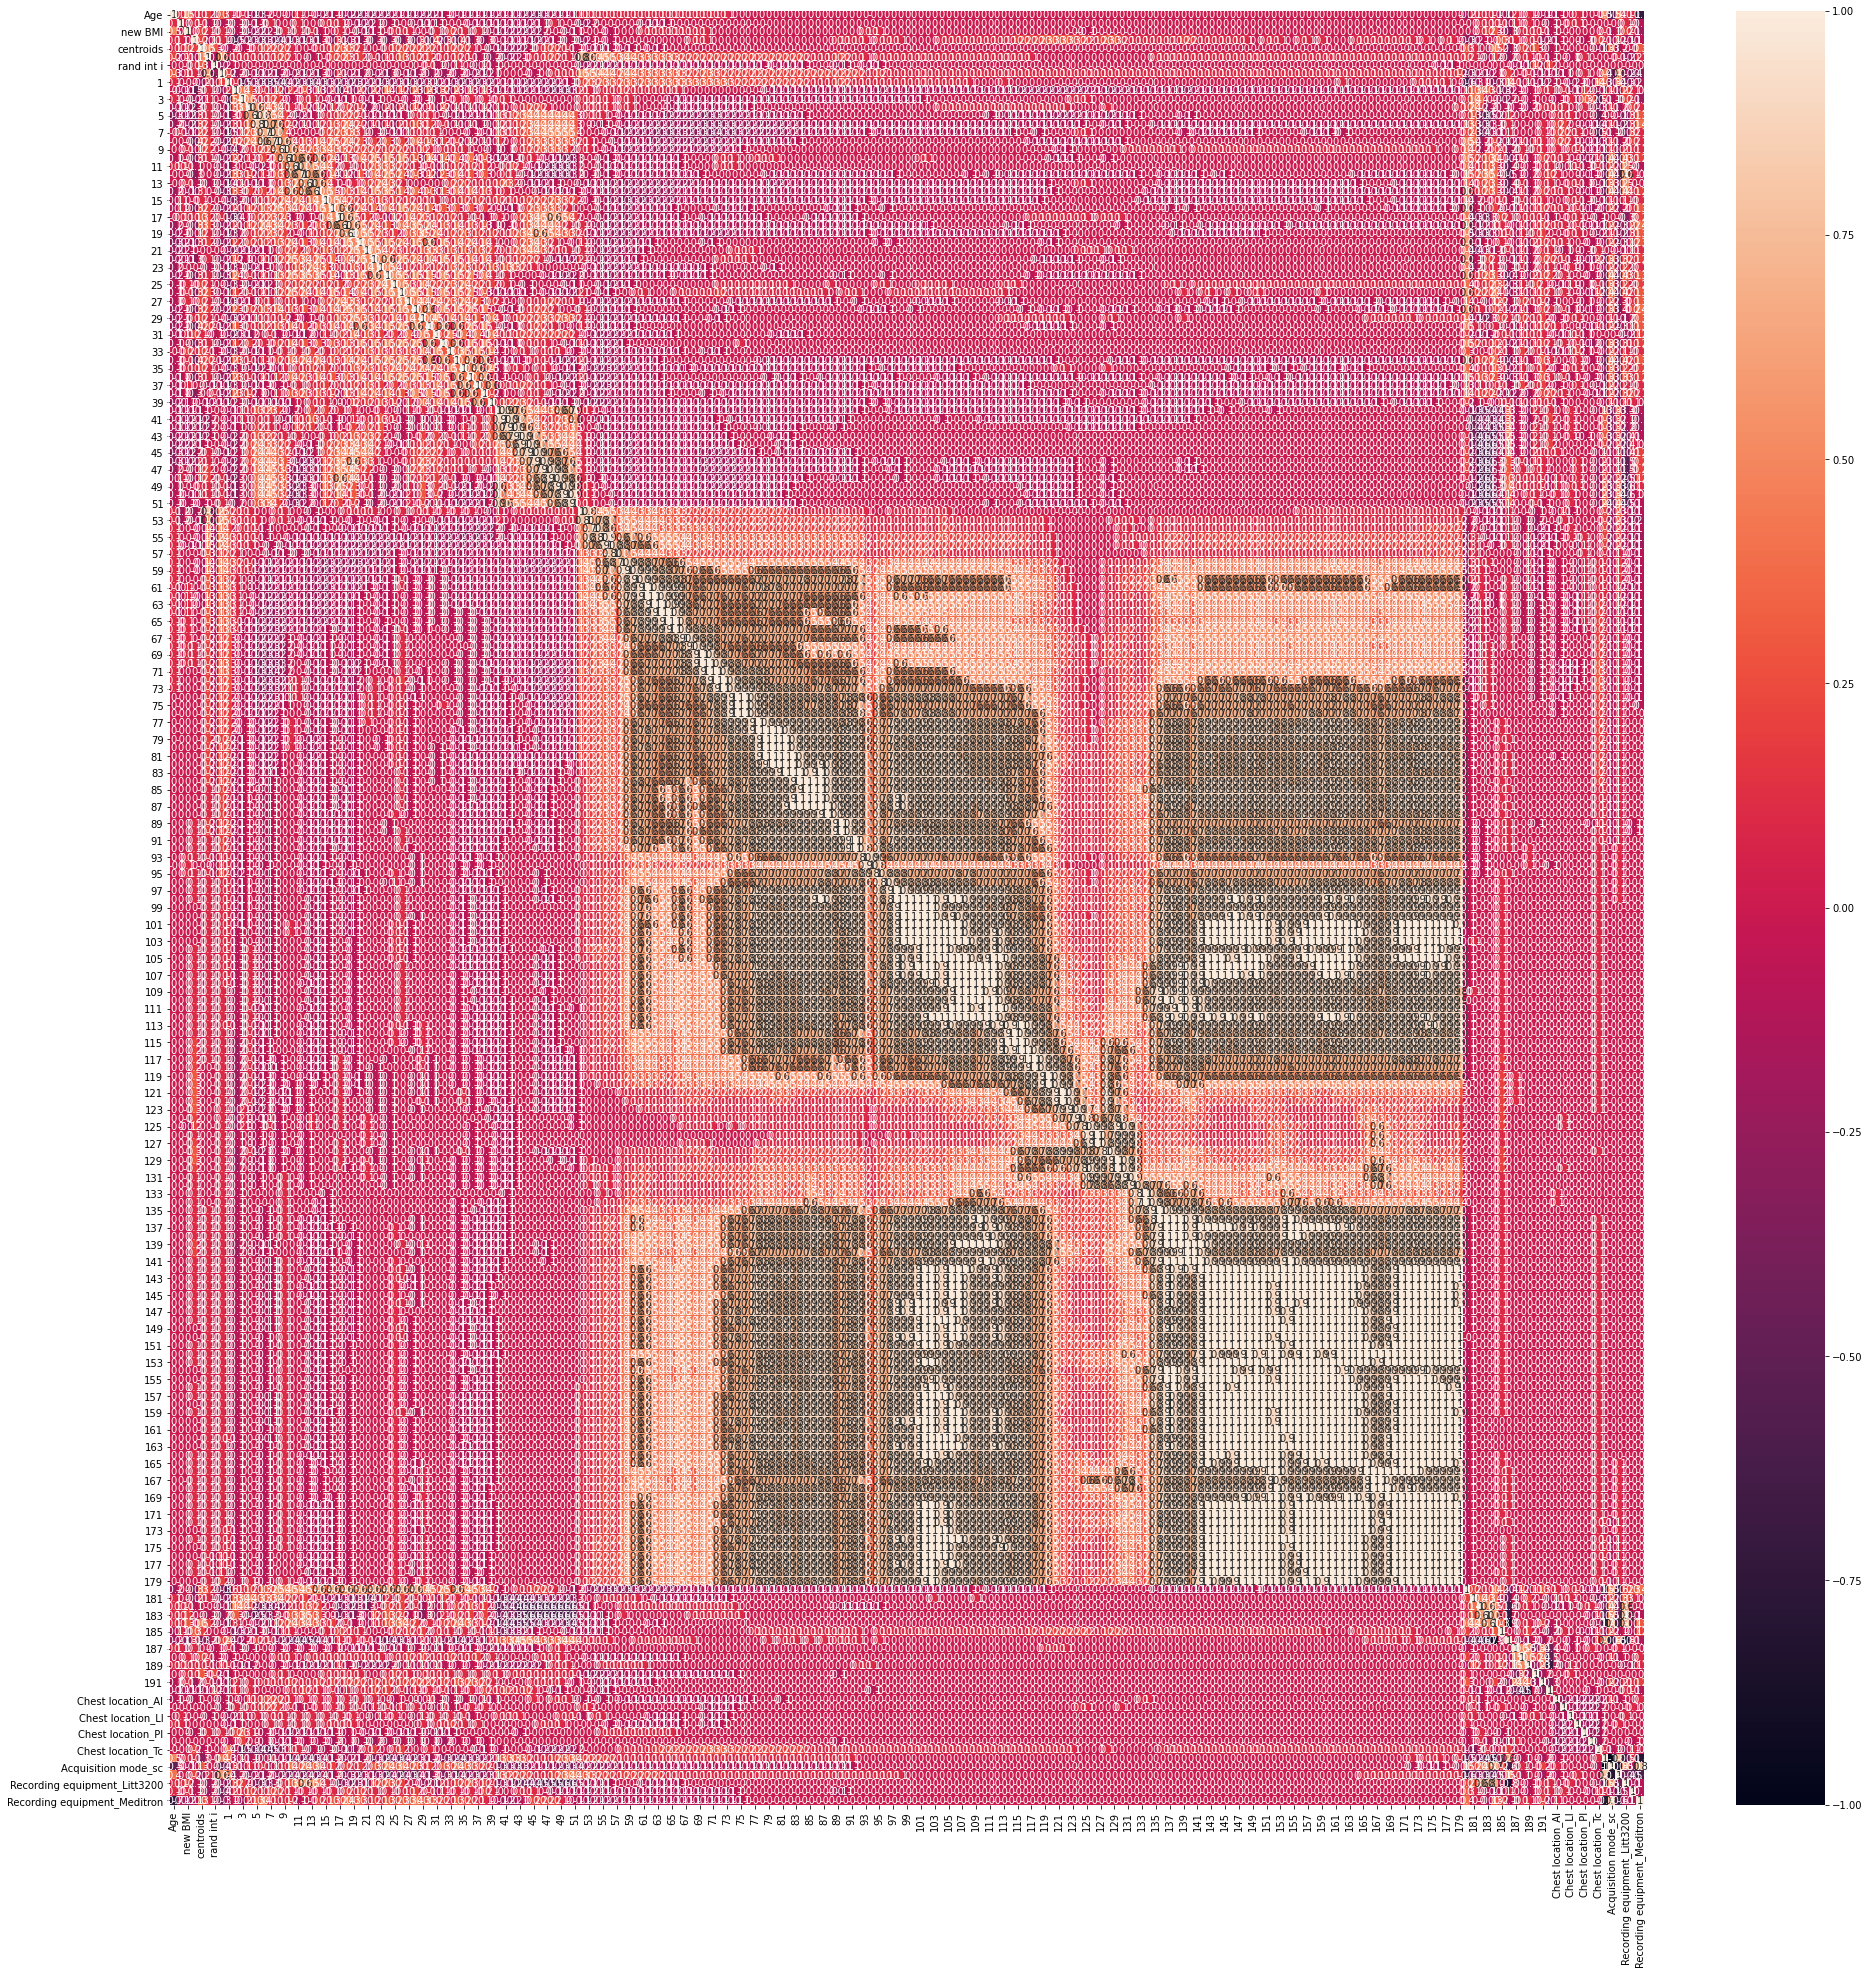

In [ ]:
plt.figure(figsize = (33,33))
sns.heatmap(dataset.corr().round(1), annot = True)

In [ ]:
dataset["Diagnosis"] = dataset["Diagnosis"].astype('category')
dataset["Diagnosis"] = dataset["Diagnosis"].cat.codes
dataset['Binary_diagnosis'] = (dataset['Binary_diagnosis'] == "Healthy").astype(int)

dataset_non_Augmented["Diagnosis"] = dataset_non_Augmented["Diagnosis"].astype('category')
dataset_non_Augmented["Diagnosis"] = dataset_non_Augmented["Diagnosis"].cat.codes
dataset_non_Augmented['Binary_diagnosis'] = (dataset_non_Augmented['Binary_diagnosis'] == "Healthy").astype(int)

dataset_Augmented["Diagnosis"] = dataset_Augmented["Diagnosis"].astype('category')
dataset_Augmented["Diagnosis"] = dataset_Augmented["Diagnosis"].cat.codes
dataset_Augmented['Binary_diagnosis'] = (dataset_Augmented['Binary_diagnosis'] == "Healthy").astype(int)

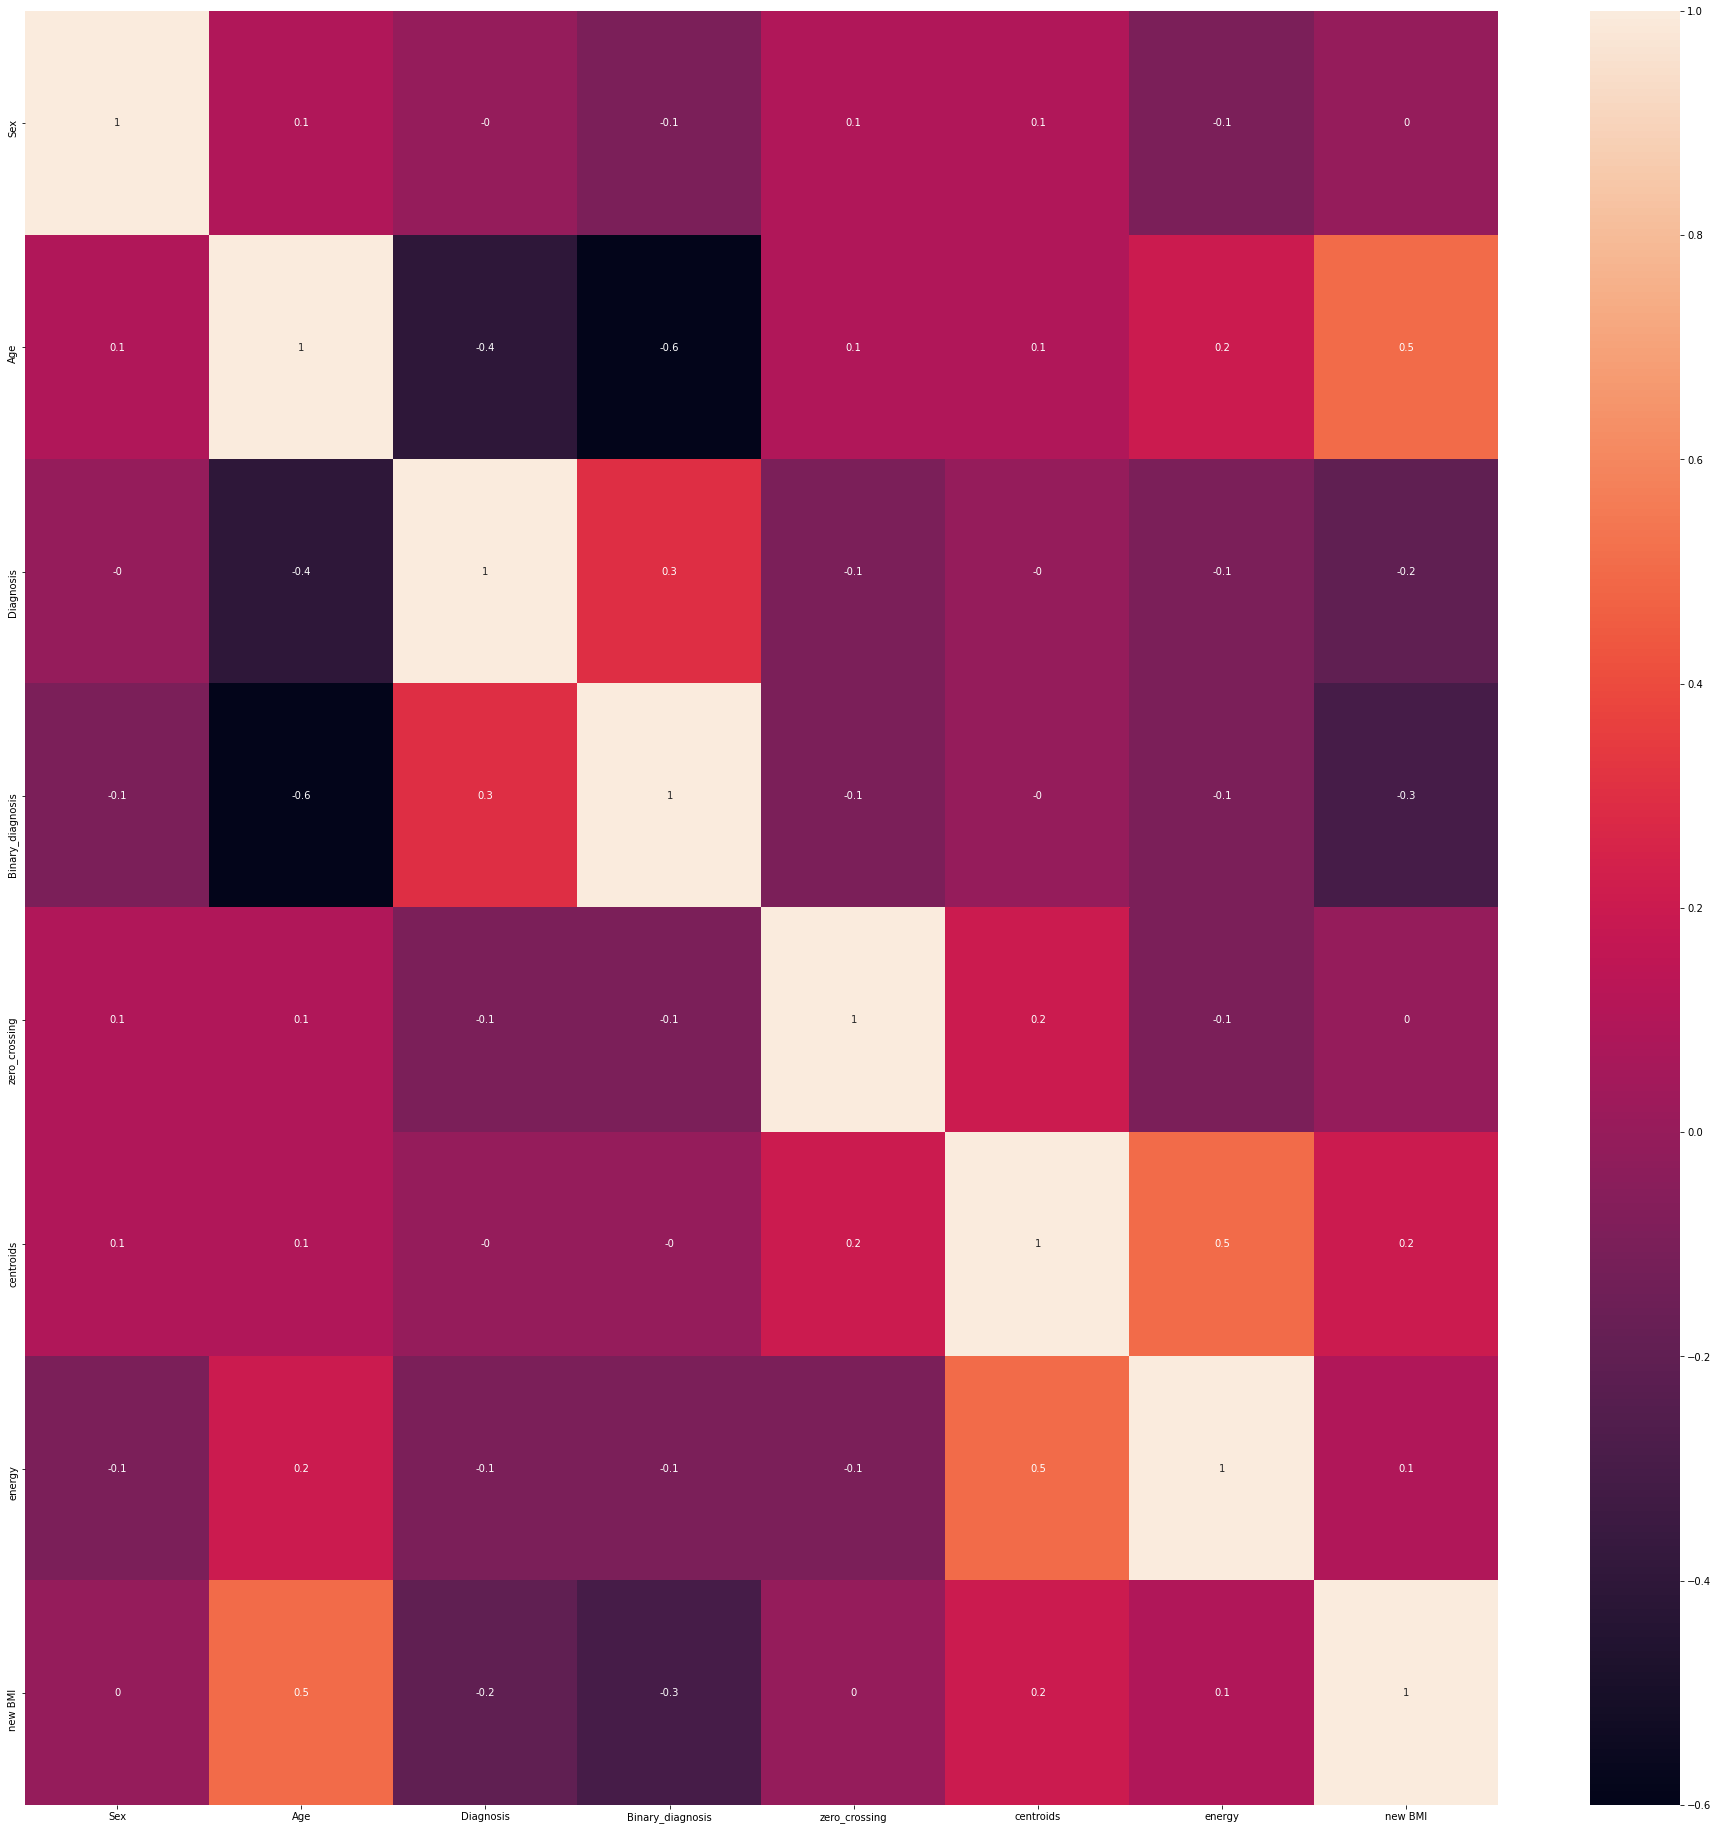

In [ ]:
correlation_heatmap = dataset[['Patient number', 'Sex' ,	'Age'	,'Diagnosis',	'Binary_diagnosis',	'zero_crossing',	'centroids',	'energy',	'new BMI']]
plt.figure(figsize = (33,33))
sns.heatmap(correlation_heatmap.corr().round(1), annot = True)

In [ ]:
print("Number of Healthy Patients: ",(dataset['Binary_diagnosis'] == 1).sum())
print("Number of Unhealthy Patients: ",(dataset['Binary_diagnosis'] == 0).sum())
print("\n")
#print("Number of Patients with Asthma are: ",(dataset['Diagnosis'] == 0).sum())
print("Number of Patients with Bronchiectasis are: ",(dataset['Diagnosis'] == 0).sum())
print("Number of Patients with Bronchiolitis are: ",(dataset['Diagnosis'] == 1).sum())
print("Number of Patients with COPD are: ",(dataset['Diagnosis'] == 2).sum())
print("Number of Patients that are Healthy, are: ",(dataset['Diagnosis'] == 3).sum())
#print("Number of Patients with LRTI are: ",(dataset['Diagnosis'] == 5).sum())
print("Number of Patients with Pneumonia are: ",(dataset['Diagnosis'] == 4).sum())
print("Number of Patients with URTI are: ",(dataset['Diagnosis'] == 5).sum())

Number of Healthy Patients:  56
Number of Unhealthy Patients:  1526


Number of Patients with Bronchiectasis are:  32
Number of Patients with Bronchiolitis are:  24
Number of Patients with COPD are:  1388
Number of Patients that are Healthy, are:  56
Number of Patients with Pneumonia are:  48
Number of Patients with URTI are:  34


## Multi Classification of Whole Dataset

In [ ]:
features = dataset.drop(columns = ['Diagnosis','Binary_diagnosis','Patient number','Recording index',"rand int i"])

targets = dataset[['Diagnosis']]

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(features, targets, test_size=0.2) # rand state sets a seed so that it will be the same 

In [ ]:
X_train_whole_dataset = X_train.values
X_test_whole_dataset = X_test.values

In [ ]:
y_train_multi_whole_dataset = y_train.values.reshape(-1,)
y_test_multi_whole_dataset = y_test.values.reshape(-1,)

## Binary Classification of Whole Dataset

In [ ]:
# targets = dataset[['Binary_diagnosis']]

# y = targets.values.reshape(-1,)

y_train_binary_whole_dataset = (y_train["Diagnosis"] == 4).astype(int).values.reshape(-1,)
y_test_binary_whole_dataset = (y_test["Diagnosis"] == 4).astype(int).values.reshape(-1,)

## Multi Classification of Augmented Dataset

In [ ]:
features = dataset_Augmented.drop(columns = ['Diagnosis','Binary_diagnosis','Patient number','Recording index',"rand int i"])
targets = dataset_Augmented[['Diagnosis']]
print(dataset_Augmented)
X_train, X_test, y_train, y_test=train_test_split(features, targets, test_size=0.2) # rand state sets a seed so that it will be the same 

     level_0  index  ... Recording equipment_LittC2SE  Recording equipment_Meditron
0          0    793  ...                            0                             1
1          1    794  ...                            0                             1
2          2    795  ...                            0                             1
3          4    797  ...                            0                             0
4          5    798  ...                            0                             0
..       ...    ...  ...                          ...                           ...
786      788   1581  ...                            0                             1
787      789   1582  ...                            0                             1
788      790   1583  ...                            0                             1
789      791   1584  ...                            1                             0
790      792   1585  ...                            0                       

In [ ]:
X_train_augmented_dataset = X_train.values
X_test_augmented_dataset = X_test.values

In [ ]:
y_train_multi = y_train.values.reshape(-1,)
y_test_multi = y_test.values.reshape(-1,)

In [ ]:
y_test_multi

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 5, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2], dtype=int8)

## Binary Classification of Augmented Dataset


In [ ]:
y_train_binary = (y_train["Diagnosis"] == 4).astype(int).values.reshape(-1,)
y_test_binary = (y_test["Diagnosis"] == 4).astype(int).values.reshape(-1,)

Training on the augmented dataset will be interesting, especially in relation to non-augmented

We want to use the same data rows, so all we do is change the X_trains to be from the non augmented dataset, now the binary and multi classification values will stay the same

In [ ]:
X_train_non = dataset_non_Augmented.loc[X_train.index].drop(columns = ['Diagnosis','Binary_diagnosis','Patient number','Recording index',"rand int i"])
X_test_non = dataset_non_Augmented.loc[X_test.index].drop(columns = ['Diagnosis','Binary_diagnosis','Patient number','Recording index',"rand int i"])

In [ ]:
X_train_non_augmented_dataset =  X_train_non.values
X_test_non_augmented_dataset = X_test_non.values

Training on the augmented dataset will be interesting, especially in relation to non-augmented

# Agglomerate Clustering

First we will work on all of the data both augmented and non augmented

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import homogeneity_score

Agg_Cluster = AgglomerativeClustering()

Agg_Cluster.fit(X_train)

y_train_predict = Agg_Cluster.fit_predict(X_train)

y_test_predict = Agg_Cluster.fit_predict(X_test)

In [ ]:
confusion_matrix_train = contingency_matrix(y_train,y_train_predict)
confusion_matrix_test = contingency_matrix(y_test,y_test_predict)

confusion = [confusion_matrix_train,confusion_matrix_test]
title = ["confusion_matrix_train","confusion_matrix_test"]
for x in confusion:
  print(x)

[[  0  12]
 [  0   9]
 [ 10 546]
 [  0  22]
 [  0  19]
 [  1  13]]
[[  3   1]
 [  3   0]
 [134   4]
 [  6   0]
 [  5   0]
 [  3   0]]


We see that our contingency matrix is just a confusion matrix, without the labels so lets make it look nice, however before we do that we also notice that their predicted cluster put everything on 1, but in actuality that clustering label is unhealthy, and is defined as 0 in our dataset

In [ ]:
y_train_predict[:] = [abs(x - 1) for x in y_train_predict]
y_test_predict[:] = [abs(x - 1) for x in y_test_predict]

In [ ]:
confusion_matrix_train = contingency_matrix(y_train,y_train_predict)
confusion_matrix_test = contingency_matrix(y_test,y_test_predict)

confusion = [confusion_matrix_train,confusion_matrix_test]
title = ["confusion_matrix_train","confusion_matrix_test"]
for x in confusion:
  print(x)

[[ 12   0]
 [  9   0]
 [546  10]
 [ 22   0]
 [ 19   0]
 [ 13   1]]
[[  1   3]
 [  0   3]
 [  4 134]
 [  0   6]
 [  0   5]
 [  0   3]]


Notice now that the data is in their correct spots according to the way we have defined it

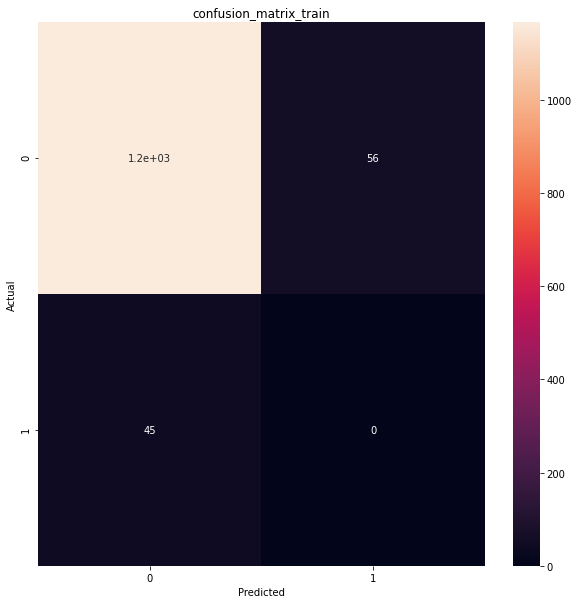

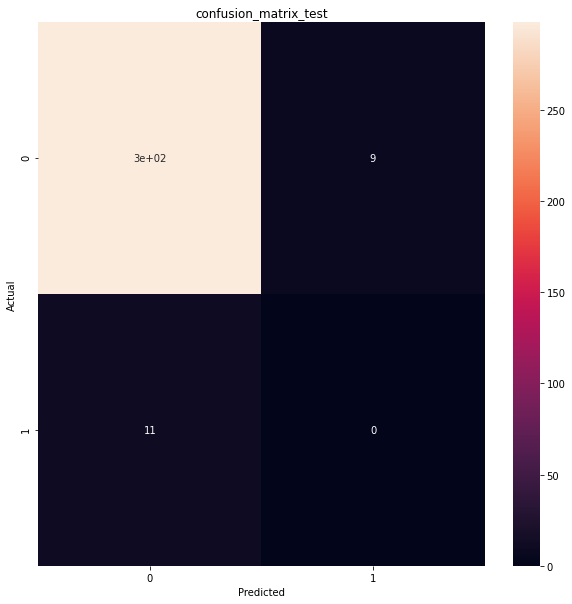

In [ ]:
for i in range(2):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(confusion[i], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(title[i])
  plt.show()
  

In [ ]:
print("**Training Score:** {}\\".format(accuracy_score(y_train,y_train_predict)))
print("**Test Score:** {}\\".format(accuracy_score(y_test,y_test_predict)))

**Training Score:** 0.9203470031545742\
**Test Score:** 0.9371069182389937\


In [ ]:
print("**Training Score:** {}\\".format(homogeneity_score(y_train,y_train_predict)))
print("**Test Score:** {}\\".format(homogeneity_score(y_test,y_test_predict)))

**Training Score:** 0.010648870371468383\
**Test Score:** 0.006723779389588885\


### Now lets change Targets to be all of the diagnosis and see if there is any difference

In [ ]:
Agg_Cluster = AgglomerativeClustering(n_clusters=8)

Agg_Cluster.fit(X_train)

y_train_predict = Agg_Cluster.fit_predict(X_train)

y_test_predict = Agg_Cluster.fit_predict(X_test)

In [ ]:
confusion_matrix_train = contingency_matrix(y_train,y_train_predict)
confusion_matrix_test = contingency_matrix(y_test,y_test_predict)

confusion = [confusion_matrix_train,confusion_matrix_test]
title = ["confusion_matrix_train","confusion_matrix_test"]

In [ ]:
confusion_matrix_test

array([[  1,   0,   0,   0,   0,   0,   0,   0],
       [  3,   0,   0,   0,   2,   3,   0,   0],
       [  3,   0,   0,   0,   0,   0,   0,   0],
       [155,  32,   4,   9,   6,  66,   1,   1],
       [ 13,   0,   0,   0,   0,   1,   0,   0],
       [  6,   0,   0,   0,   0,   0,   0,   0],
       [ 11,   0,   0,   0,   0,   1,   0,   0]])

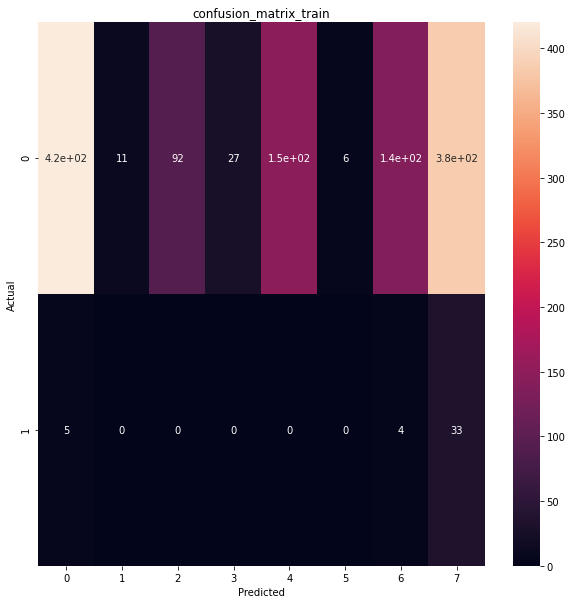

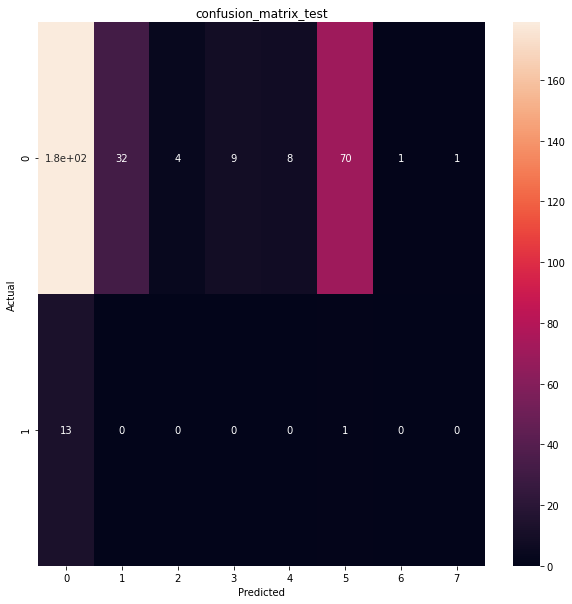

In [ ]:
for i in range(2):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(confusion[i], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(title[i])
  plt.show()
  

In [ ]:
print("**Training Score:** {}\\".format(homogeneity_score(y_train,y_train_predict)))
print("**Validation Score:** {}\\".format(homogeneity_score(y_val,y_valid_predict)))
print("**Test Score:** {}\\".format(homogeneity_score(y_test,y_test_predict)))

**Training Score:** 0.13497332491260722\
**Validation Score:** 0.24397603881049418\
**Test Score:** 0.0960290366334938\


## Binary Classification:

**Training Score:** 0.001812854636527089\
**Validation Score:** 0.01021899390226609\
**Test Score:** 0.010783291182002285

## Multi Classification:

**Training Score:** 0.19128155848883716\
**Validation Score:** 0.24404191663198627\
**Test Score:** 0.341059022281443

We can see that our Multi Classification worked overall much better then our Binary.\
Why is this the case?

Let's investigate.

In [ ]:
print("Number of Healthy Patients: ",(dataset['Binary_diagnosis'] == 1).sum())
print("Number of Unhealthy Patients: ",(dataset['Binary_diagnosis'] == 0).sum())

Number of Healthy Patients:  56
Number of Unhealthy Patients:  1530


In [ ]:
print("Number of Patients with Asthma are: ",(dataset['Diagnosis'] == 0).sum())
print("Number of Patients with Bronchiectasis are: ",(dataset['Diagnosis'] == 1).sum())
print("Number of Patients with Bronchiolitis are: ",(dataset['Diagnosis'] == 2).sum())
print("Number of Patients with COPD are: ",(dataset['Diagnosis'] == 3).sum())
print("Number of Patients with Healthy are: ",(dataset['Diagnosis'] == 4).sum())
print("Number of Patients with LRTI are: ",(dataset['Diagnosis'] == 5).sum())
print("Number of Patients with Pneumonia are: ",(dataset['Diagnosis'] == 6).sum())
print("Number of Patients with URTI are: ",(dataset['Diagnosis'] == 7).sum())

As we can see here, we have a huge data imbalance when we choose Binary with 765 sick. This is because Agglomertaive clustering is unsupervised in nature and thus it is trying to look and identify patterns within the data to then cluster together.Thus the model will believe that everybody will be sick. However even with 694 COPD, (which just gives us a difference of 69) it makes a world of difference. Given that 6 more labels are used for those 69 extra patients.

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
linear_regressor = LinearRegression()

# Train the model on the training data
linear_regressor.fit(X_train, y_train)

y_predict = linear_regressor.predict(X_test)

cross_val_scores = cross_val_score(linear_regressor, X , y)

print("**Training Score:** {}\\".format(linear_regressor.score(X_train, y_train)))
print("**Validation Score:** {}\\".format(linear_regressor.score(X_val, y_val)))
print("**Test Score:** {}\\".format(linear_regressor.score(X_test, y_test)))
print("**Mean Squared Error:** {}\\".format(mean_squared_error(y_test, y_predict)))
print("**R2:** {}\\".format(r2_score(y_test, y_predict)))
print("**Accuracy:** {}\\".format(cross_val_scores.mean()))
print("**Standard Deviation:** {}".format(cross_val_scores.std()))

**Training Score:** 0.7313958532228526\
**Validation Score:** -751.0012538581755\
**Test Score:** -160032810042718.44\
**Mean Squared Error:** 5198438854576.015\
**R2:** -160032810042718.44\
**Accuracy:** -2922762041999611.0\
**Standard Deviation:** 5845524083855530.0


**Training Score:** 0.5471429949855255\
**Validation Score:** -1631.2089520180195\
**Test Score:** -75.63409963566522\
**Mean Squared Error:** 92.23616090004434\
**R2:** -75.63409963566522\
**Accuracy:** -1.3532494069768252e+16\
**Standard Deviation:** 2.7064988139203736e+16

In [ ]:
from sklearn.svm import SVC

svr_regressor = SVC()

svr_regressor.fit(X_train, y_train)

y_predict = svr_regressor.predict(X_test)

cross_val_scores = cross_val_score(svr_regressor, X , y)
print("**Training Score:** {}\\".format(svr_regressor.score(X_train, y_train)))
print("**Validation Score:** {}\\".format(svr_regressor.score(X_val, y_val)))
print("**Test Score:** {}\\".format(svr_regressor.score(X_test, y_test)))
print("**Mean Squared Error:** {}\\".format(mean_squared_error(y_test, y_predict)))
print("**R2:** {}\\".format(r2_score(y_test, y_predict)))
print("**Accuracy:** {}\\".format(cross_val_scores.mean()))
print("**Standard Deviation:** {}".format(cross_val_scores.std()))

**Training Score:** 0.9644970414201184\
**Validation Score:** 0.9763779527559056\
**Test Score:** 0.9559748427672956\
**Mean Squared Error:** 0.0440251572327044\
**R2:** -0.046052631578947345\
**Accuracy:** 0.9646925778227488\
**Standard Deviation:** 0.0012142134396762039


**Training Score:** 0.9664948453608248\
**Validation Score:** 0.9580838323353293\
**Test Score:** 0.9663865546218487\
**Mean Squared Error:** 0.03361344537815126\
**R2:** -0.034782608695652195\
**Accuracy:** 0.9647002627179365\
**Standard Deviation:** 0.0029836154020048485

**Training Score:** 0.8856015779092702\
**Validation Score:** 0.889763779527559\
**Test Score:** 0.8301886792452831\
**Mean Squared Error:** 1.2767295597484276\
**R2:** -0.06076639936900241\
**Accuracy:** 0.8751691744287877\
**Standard Deviation:** 0.004386802923024295

# Sequential Modelling


collecting required data

In [ ]:
dataset_sequential.columns = dataset_sequential.columns.map(str)

start = dataset_sequential.columns.get_loc("0") 
end = dataset_sequential.columns.get_loc("192")

data = dataset_sequential.iloc[:, start: end]

patient_diagnosis = dataset_sequential.iloc[:, dataset_sequential.columns.get_loc("Diagnosis")]

refining and spliting data

In [ ]:
def data_points():
    labels = []
    images = []

    to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

    #count = 0
    for i in range (0, 793):
      labels.append(to_hot_one[patient_diagnosis[i]])
      images.append(np.array(data.iloc[i, :]))

    return np.array(labels), np.array(images)

In [ ]:
def preprocessing(labels, images):    

  # Remove Asthma and LRTI
    images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
    labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)      
    
  # Split data
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

  # Hot one encode the labels
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)  

  # Format new data
    y_train = np.reshape(y_train, (y_train.shape[0], 6))
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 6))
    X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

    return X_train, X_test, y_train, y_test

In [ ]:
labels, images = data_points()

In [ ]:
X_train, X_test, y_train, y_test = preprocessing(labels, images)

sequential model implimentation and training

In [ ]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(SeparableConv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(SeparableConv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=200, verbose=1)

Epoch 1/70
4/4 [==============================] - 3s 499ms/step - loss: 1.2933 - accuracy: 0.6456 - val_loss: 0.5799 - val_accuracy: 0.8742
Epoch 2/70
4/4 [==============================] - 2s 413ms/step - loss: 0.5903 - accuracy: 0.8782 - val_loss: 0.6417 - val_accuracy: 0.8742
Epoch 3/70
4/4 [==============================] - 2s 420ms/step - loss: 0.6130 - accuracy: 0.8782 - val_loss: 0.5336 - val_accuracy: 0.8742
Epoch 4/70
4/4 [==============================] - 2s 406ms/step - loss: 0.5128 - accuracy: 0.8782 - val_loss: 0.5140 - val_accuracy: 0.8742
Epoch 5/70
4/4 [==============================] - 2s 403ms/step - loss: 0.5085 - accuracy: 0.8782 - val_loss: 0.5109 - val_accuracy: 0.8742
Epoch 6/70
4/4 [==============================] - 2s 404ms/step - loss: 0.4852 - accuracy: 0.8782 - val_loss: 0.5036 - val_accuracy: 0.8742
Epoch 7/70
4/4 [==============================] - 2s 403ms/step - loss: 0.4950 - accuracy: 0.8782 - val_loss: 0.5207 - val_accuracy: 0.8742
Epoch 8/70
4/4 [====

visualizing the results

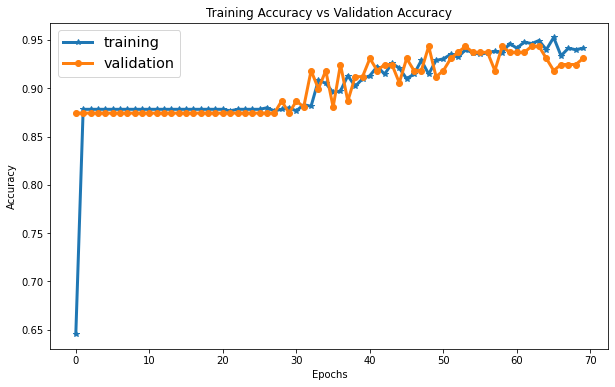

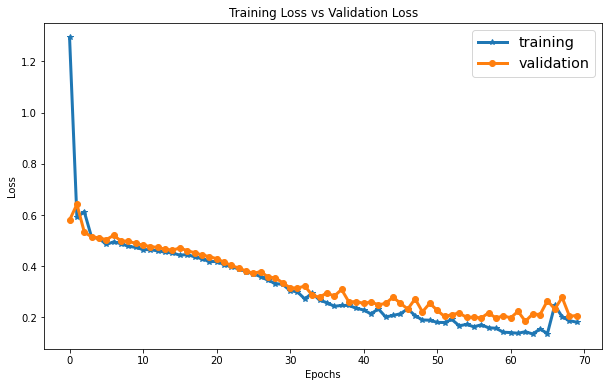

In [ ]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(history)

                precision    recall  f1-score   support

          COPD       0.97      1.00      0.98       139
       Healthy       0.57      0.67      0.62         6
          URTI       0.00      0.00      0.00         3
Bronchiectasis       0.75      1.00      0.86         3
     Pneumoina       1.00      0.50      0.67         4
 Bronchiolitis       0.00      0.00      0.00         4

      accuracy                           0.93       159
     macro avg       0.55      0.53      0.52       159
  weighted avg       0.90      0.93      0.91       159



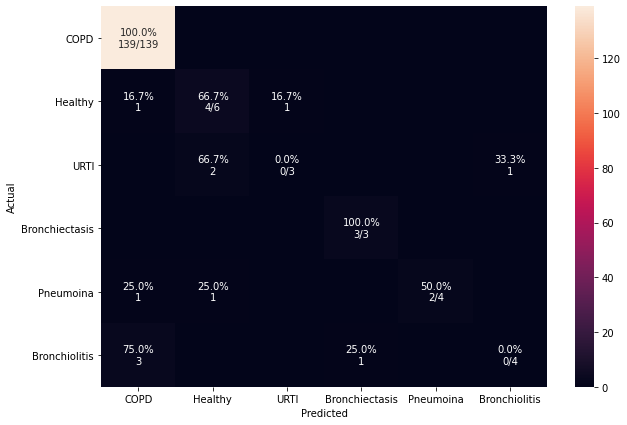

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')

evaluating model's efficiency

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 26ms/step - loss: 0.2074 - accuracy: 0.9308


[0.20736163854599, 0.9308176040649414]

#K-Means Model

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Binary Diagnosis - Whole Data

In [210]:
pca = PCA(2)

X_pca_train = pca.fit_transform(X_train_whole_dataset)
X_pca_test = pca.fit_transform(X_test_whole_dataset)
k_means_model = KMeans(n_clusters = 2) 
k_means_model.fit(X_pca_train)

y_train_predict = k_means_model.predict(X_pca_train)
y_test_predict = k_means_model.predict(X_pca_test)

In [208]:
!pwd
%cd ../report_figures/

/content/gdrive/My Drive/CMPT 340 Project/audio_and_txt_files
/content/gdrive/My Drive/CMPT 340 Project/report_figures


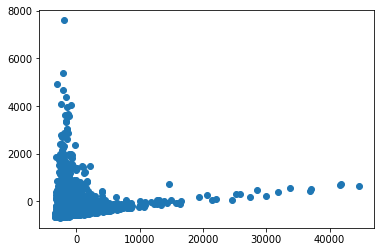

In [274]:
plt.scatter(X_pca_train[:, 0] , X_pca_train[: , 1])
plt.savefig('whole_data.png')


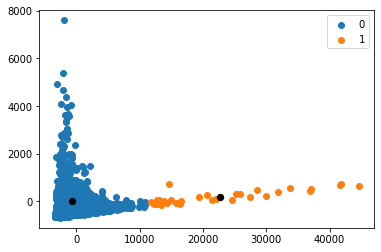

In [212]:
u_labels = np.unique(y_train_predict)
centroids = k_means_model.cluster_centers_

for i in u_labels:
    plt.scatter(X_pca_train[y_train_predict == i , 0] , X_pca_train[y_train_predict == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 40, color = 'k')
plt.savefig('KMeans_binary_whole_data.png')
plt.legend()
plt.show()

Clearly we can see from this that 0 must be our unhealthy and 1 must be healthy.  This is easy to re-label 

In [ ]:
confusion_matrix_train = contingency_matrix(y_train_binary_whole_dataset,y_train_predict)
confusion_matrix_test = contingency_matrix(y_test_binary_whole_dataset,y_test_predict)

confusion = [confusion_matrix_train,confusion_matrix_test]
title = ["confusion_matrix_train","confusion_matrix_test"]
for x in confusion:
  print(x)

[[1195   32]
 [  38    0]]
[[293  14]
 [ 10   0]]


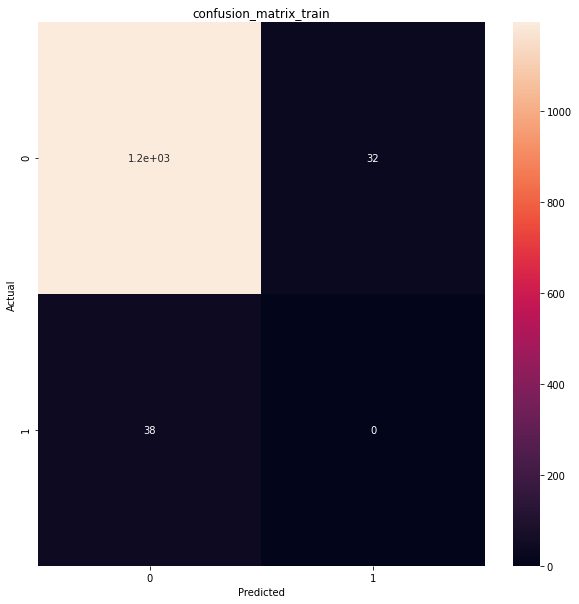

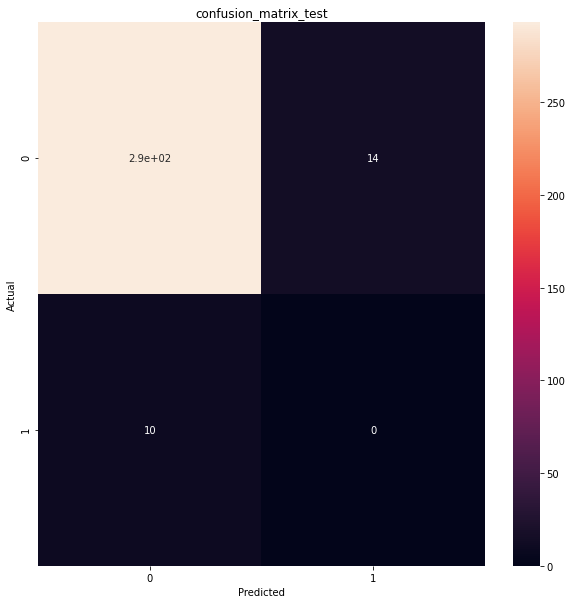

In [ ]:
for i in range(2):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(confusion[i], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(title[i])
  plt.show()

In [213]:
print("**Training Score:** {}\\".format(accuracy_score(y_train_binary_whole_dataset,y_train_predict)))
print("**Test Score:** {}\\".format(accuracy_score(y_test_binary_whole_dataset,y_test_predict)))

**Training Score:** 0.9446640316205533\
**Test Score:** 0.9242902208201893\


### Multi Diagnosis - Whole Data

In [214]:
k_means_model = KMeans(n_clusters=6)

k_means_model.fit(X_pca_train)

y_train_predict = k_means_model.predict(X_pca_train)
y_test_predict = k_means_model.predict(X_pca_test)


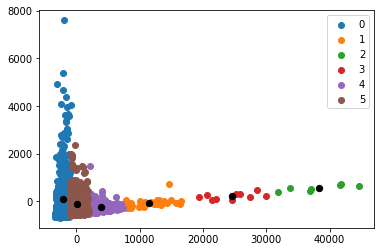

In [215]:
u_labels = np.unique(y_train_predict)
centroids = k_means_model.cluster_centers_

for i in u_labels:
    plt.scatter(X_pca_train[y_train_predict == i , 0] , X_pca_train[y_train_predict == i , 1] , label = i)
 
plt.scatter(centroids[:,0] , centroids[:,1] , s = 40, color = 'k')
plt.savefig('KMeans_multi_whole_data.png')

plt.legend()
plt.show()

Which cluster is healthy?  Which is unhealthy?  This becomes a challenge

In [216]:
confusion_matrix_train = contingency_matrix(y_train_multi_whole_dataset,y_train_predict)
confusion_matrix_test = contingency_matrix(y_test_multi_whole_dataset,y_test_predict)

confusion = [confusion_matrix_train,confusion_matrix_test]
title = ["confusion_matrix_train","confusion_matrix_test"]

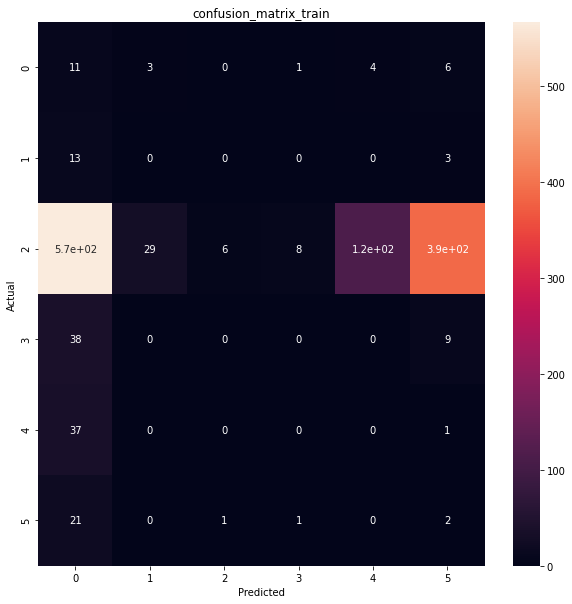

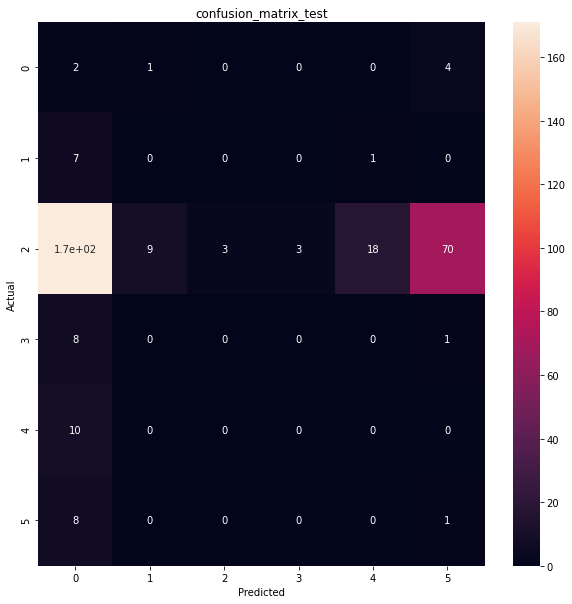

In [217]:
for i in range(2):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(confusion[i], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(title[i])
  plt.show()

In [218]:
print("**Training Score:** {}\\".format(accuracy_score(y_train_multi_whole_dataset,y_train_predict)))
print("**Test Score:** {}\\".format(accuracy_score(y_test_multi_whole_dataset,y_test_predict)))

**Training Score:** 0.015019762845849802\
**Test Score:** 0.01892744479495268\


### Binary Diagnosis - Non Augmented

In [227]:
X_pca_train_non_augmented = pca.fit_transform(X_train_non_augmented_dataset)
X_pca_test_non_augmented = pca.fit_transform(X_test_non_augmented_dataset)

k_means_model = KMeans(n_clusters=2)

k_means_model.fit(X_pca_train_non_augmented)

y_train_predict = k_means_model.predict(X_pca_train_non_augmented)

y_test_predict = k_means_model.predict(X_pca_test_non_augmented)

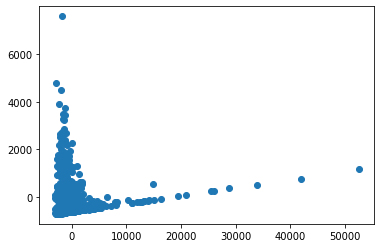

In [273]:
 plt.scatter(X_pca_train_non_augmented[: , 0] , X_pca_train_non_augmented[: , 1])
 plt.savefig('non_augmented.png')

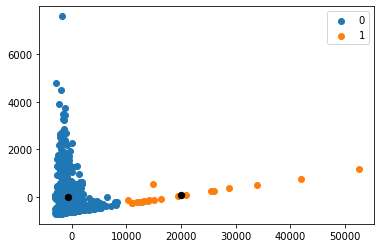

In [228]:
u_labels = np.unique(y_train_predict)
centroids = k_means_model.cluster_centers_

for i in u_labels:
    plt.scatter(X_pca_train_non_augmented[y_train_predict == i , 0] , X_pca_train_non_augmented[y_train_predict == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 40, color = 'k')
plt.savefig('KMeans_binary_non_augmented_data.png')
plt.legend()
plt.show()

In [229]:
confusion_matrix_train = contingency_matrix(y_train_binary,y_train_predict)
confusion_matrix_test = contingency_matrix(y_test_binary,y_test_predict)

confusion = [confusion_matrix_train,confusion_matrix_test]
title = ["confusion_matrix_train_non_augment","confusion_matrix_test_non_augment"]
for x in confusion:
  print(x)

[[591  21]
 [ 20   0]]
[[154   1]
 [  4   0]]


We see that our contingency matrix is just a confusion matrix, without the labels so lets make it look nice, however before we do that we also notice that their predicted cluster put everything on 1, but in actuality that clustering label is unhealthy, and is defined as 0 in our dataset

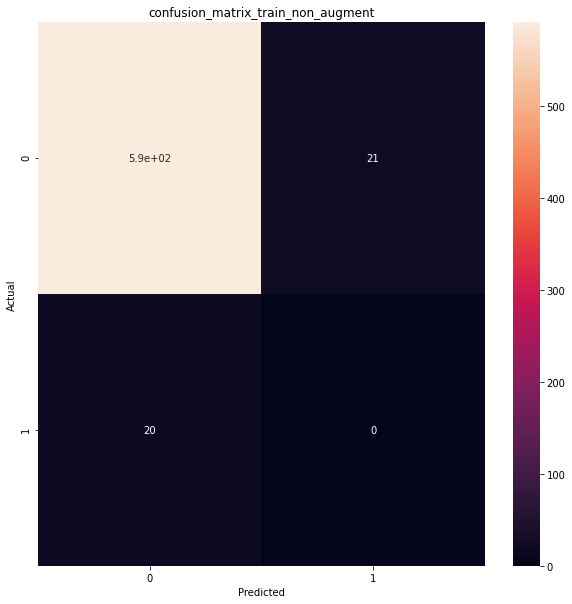

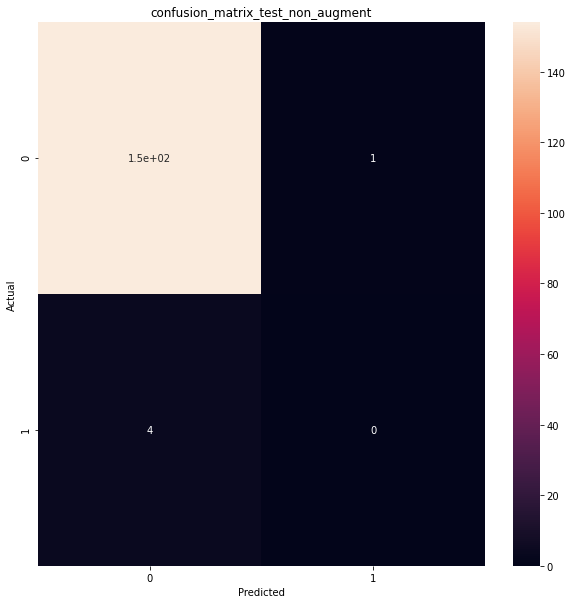

In [230]:
for i in range(2):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(confusion[i], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(title[i])
  plt.show()

In [231]:
print("**Training Score:** {}\\".format(accuracy_score(y_train_binary,y_train_predict)))
print("**Test Score:** {}\\".format(accuracy_score(y_test_binary,y_test_predict)))

**Training Score:** 0.935126582278481\
**Test Score:** 0.9685534591194969\


### Multi Diagnosis - Non Augmented

In [232]:
k_means_model = KMeans(n_clusters=6)

k_means_model.fit(X_pca_train_non_augmented)

y_train_predict = k_means_model.predict(X_pca_train_non_augmented)
y_test_predict = k_means_model.predict(X_pca_test_non_augmented)


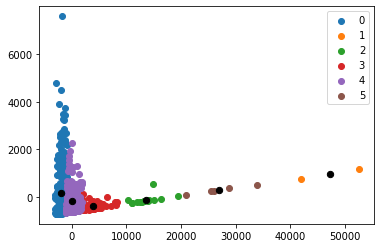

In [237]:
u_labels = np.unique(y_train_predict)
centroids = k_means_model.cluster_centers_

for i in u_labels:
    plt.scatter(X_pca_train_non_augmented[y_train_predict == i , 0] , X_pca_train_non_augmented[y_train_predict == i , 1] , label = i)

plt.scatter(centroids[:,0] , centroids[:,1] , s = 40, color = 'k')
plt.savefig('KMeans_multi_non_augmented_data.png')


plt.legend()
plt.show()

In [234]:
confusion_matrix_train = contingency_matrix(y_train_multi,y_train_predict)
confusion_matrix_test = contingency_matrix(y_test_multi,y_test_predict)

confusion = [confusion_matrix_train,confusion_matrix_test]
title = ["confusion_matrix_train","confusion_matrix_test"]

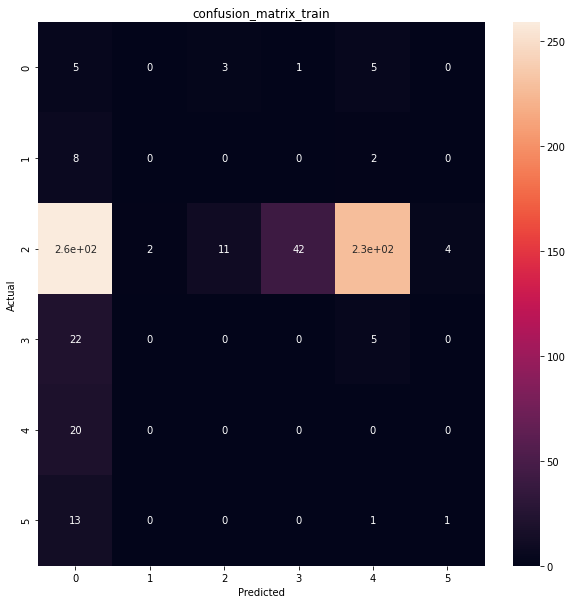

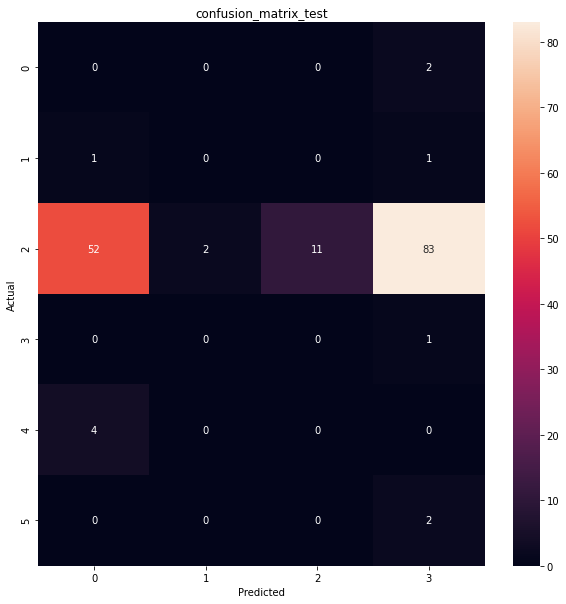

In [235]:
for i in range(2):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(confusion[i], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(title[i])
  plt.show()

In [236]:
print("**Training Score:** {}\\".format(accuracy_score(y_train_multi,y_train_predict)))
print("**Test Score:** {}\\".format(accuracy_score(y_test_multi,y_test_predict)))

**Training Score:** 0.02689873417721519\
**Test Score:** 0.012578616352201259\


### Binary Diagnosis - Augmented

In [264]:
X_pca_train_augmented = pca.fit_transform(X_train_augmented_dataset)
X_pca_test_augmented = pca.fit_transform(X_test_augmented_dataset)

k_means_model = KMeans(n_clusters=2)

k_means_model.fit(X_pca_train_augmented)

y_train_predict = k_means_model.predict(X_pca_train_augmented)

y_test_predict = k_means_model.predict(X_pca_test_augmented)

In [265]:
confusion_matrix_train = contingency_matrix(y_train_binary,y_train_predict)
confusion_matrix_test = contingency_matrix(y_test_binary,y_test_predict)

confusion = [confusion_matrix_train,confusion_matrix_test]
title = ["confusion_matrix_train_non_augment","confusion_matrix_test_non_augment"]
for x in confusion:
  print(x)

[[599  13]
 [ 20   0]]
[[153   2]
 [  4   0]]


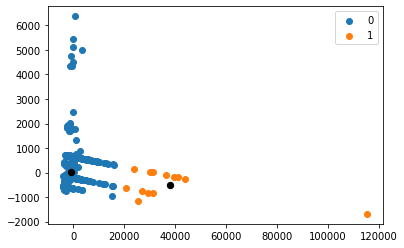

In [266]:
u_labels = np.unique(y_train_predict)
centroids = k_means_model.cluster_centers_

for i in u_labels:
    plt.scatter(X_pca_train_augmented[y_train_predict == i , 0] , X_pca_train_augmented[y_train_predict == i , 1] , label = i)
 
plt.scatter(centroids[:,0] , centroids[:,1] , s = 40, color = 'k')
plt.savefig('KMeans_binary_augmented_data.png')


plt.legend()
plt.show()

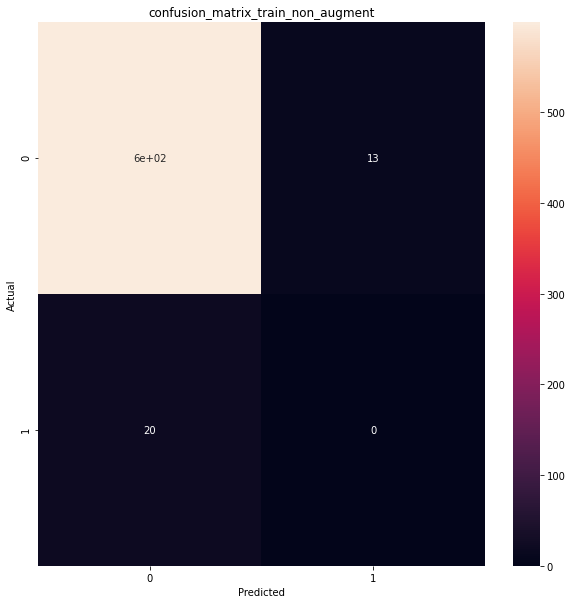

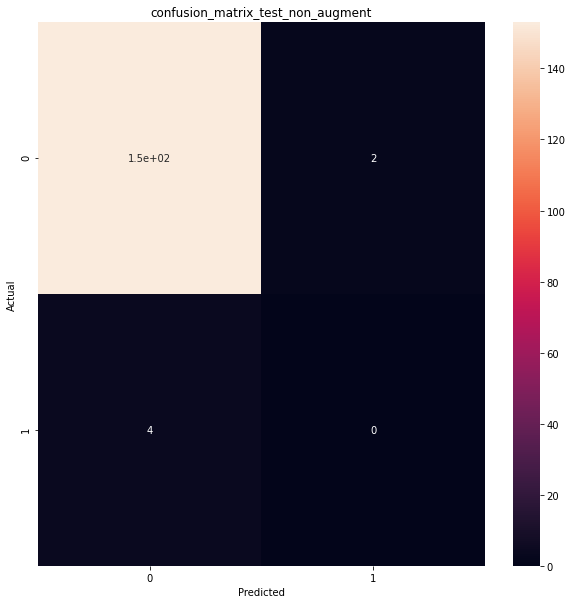

In [267]:
for i in range(2):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(confusion[i], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(title[i])
  plt.show()

In [268]:
print("**Training Score:** {}\\".format(accuracy_score(y_train_binary,y_train_predict)))
print("**Test Score:** {}\\".format(accuracy_score(y_test_binary,y_test_predict)))

**Training Score:** 0.9477848101265823\
**Test Score:** 0.9622641509433962\


### Multi Diagnosis - Augmented

In [242]:
k_means_model = KMeans(n_clusters=6)

k_means_model.fit(X_pca_train_augmented)

y_train_predict = k_means_model.predict(X_pca_train_augmented)
y_test_predict = k_means_model.predict(X_pca_test_augmented)


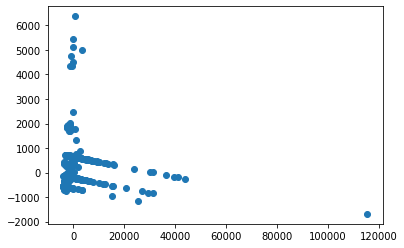

In [272]:
plt.scatter(X_pca_train_augmented[:,0], X_pca_train_augmented[: , 1])
plt.savefig('augmented_data.png')

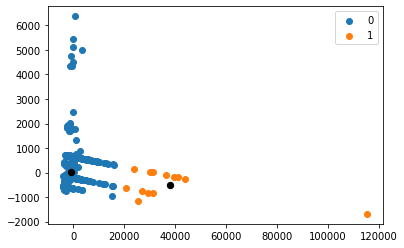

In [269]:
u_labels = np.unique(y_train_predict)
centroids = k_means_model.cluster_centers_

for i in u_labels:
    plt.scatter(X_pca_train_augmented[y_train_predict == i , 0] , X_pca_train_augmented[y_train_predict == i , 1] , label = i)
 
plt.scatter(centroids[:,0] , centroids[:,1] , s = 40, color = 'k')
plt.savefig('KMeans_multi_augmented_data.png')

plt.legend()
plt.show()

In [245]:
confusion_matrix_train = contingency_matrix(y_train_multi,y_train_predict)
confusion_matrix_test = contingency_matrix(y_test_multi,y_test_predict)

confusion = [confusion_matrix_train,confusion_matrix_test]
title = ["confusion_matrix_train","confusion_matrix_test"]

In [254]:
confusion_matrix_train

array([[  3,   1,   6,   3,   0,   1],
       [  1,   0,   8,   1,   0,   0],
       [174,  16, 283,  63,   1,   9],
       [  2,   0,  25,   0,   0,   0],
       [  1,   0,  19,   0,   0,   0],
       [  0,   0,  14,   0,   0,   1]])

In [253]:
confusion_matrix_train = confusion_matrix_train[:,[0,1,5,3,4,2]]
confusion = [confusion_matrix_train,confusion_matrix_test]


In [257]:
confusion_matrix_test

array([[ 1,  0,  1,  0,  0],
       [ 1,  0,  1,  0,  0],
       [53,  4, 70,  1, 20],
       [ 1,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0],
       [ 2,  0,  0,  0,  0]])

In [256]:
confusion_matrix_test = confusion_matrix_test[:,[0,1,4,3,2]]
confusion = [confusion_matrix_train,confusion_matrix_test]


In [258]:
y_train_predict2 = np.where(y_train_predict == 2, -1, y_train_predict)
y_train_predict2 = np.where(y_train_predict2 == 5, 2, y_train_predict2)
y_train_predict2 = np.where(y_train_predict2 == -1, 5, y_train_predict2)

In [259]:
y_test_predict2 = np.where(y_test_predict == 2, -1, y_test_predict)
y_test_predict2 = np.where(y_test_predict == 4, 2, y_test_predict)
y_test_predict2 = np.where(y_test_predict == -1, 4, y_test_predict)

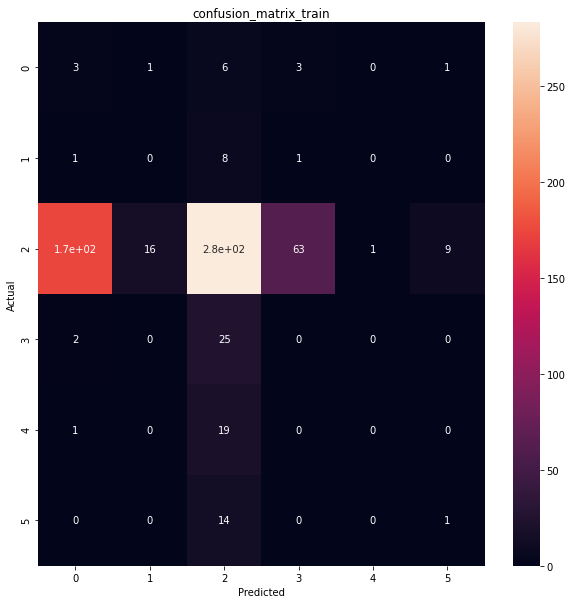

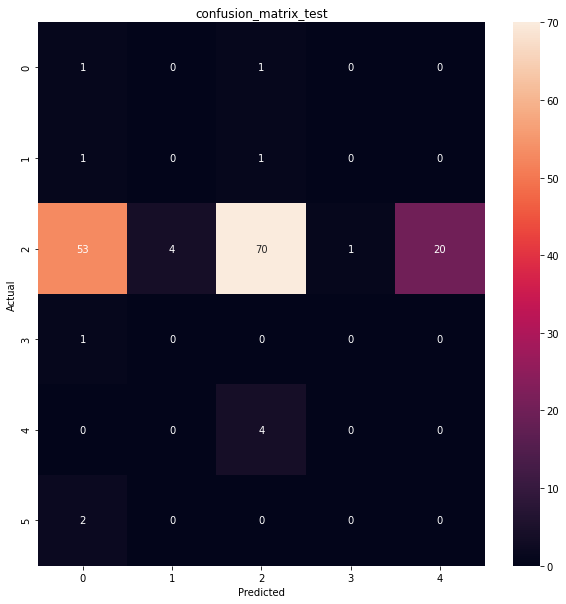

In [260]:
for i in range(2):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(confusion[i], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(title[i])
  plt.show()

In [261]:
print("**Training Score:** {}\\".format(accuracy_score(y_train_multi,y_train_predict)))
print("**Test Score:** {}\\".format(accuracy_score(y_test_multi,y_test_predict)))

**Training Score:** 0.028481012658227847\
**Test Score:** 0.006289308176100629\


In [262]:
print("**Training Score:** {}\\".format(accuracy_score(y_train_multi,y_train_predict2)))
print("**Test Score:** {}\\".format(accuracy_score(y_test_multi,y_test_predict2)))

**Training Score:** 0.4525316455696203\
**Test Score:** 0.006289308176100629\
